In [1]:
# just here
%load_ext autoreload
%autoreload 2

In [33]:
# imports
import numpy as np
import pandas as pd
import pynapple as nap
import matplotlib.pyplot as plt
import iblphotometry.loaders as loaders
import iblphotometry.plots as plots

In [3]:
# ONE instantiation
from one.api import ONE
one = ONE(base_url="https://alyx.internationalbrainlab.org", mode='remote')

In [43]:
# load data via data_loader
eids = one.search(dataset='photometry.signal.pqt')
eid = eids[2]

data_loader = loaders.PhotometryLoader(one)
raw_photometry = data_loader.load_photometry_data(eid, signal='GCaMP')
trials = data_loader.load_trials_table(eid)

In [44]:
from iblphotometry.outlier_detection import remove_spikes
from iblphotometry.pipelines import bc_lp_sliding_mad

# manual steps through pipeline
photometry = remove_spikes(raw_photometry, sd=5)
roi_name = data_loader.get_mapping(eid, 'brain_region', 'ROI')['DMS']
photometry = bc_lp_sliding_mad(photometry, signal_name=roi_name)

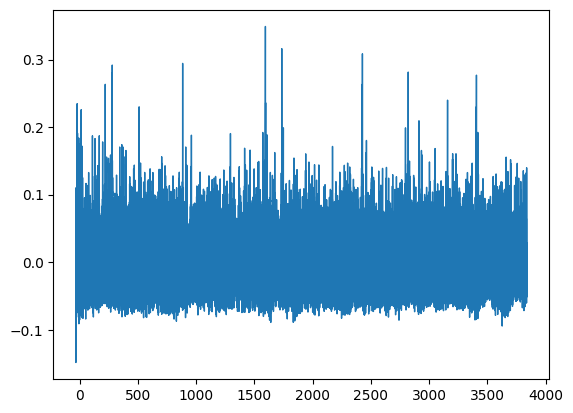

In [45]:
fig, axes = plt.subplots()
axes.plot(photometry,lw=1)